# Image Classification from Scratch

+ Training an Image Classifier from Scratch on Kaggle Cats and Dogs Dataset.
+ Dataset :- Kaggle Cats and Dogs Dataset.
+ We will be training the Model from Scratch.
+ Without taking advantage of Pretrained Model.
+ without leveraging pre-trained weights or a pre-made Keras Application model.


SETUP

In [1]:
## set up
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

LOAD THE DATASET

In [2]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
## unzip the data
!unzip -q kagglecatsanddogs_5340.zip
## check the list of the Unzip file
!ls
## check the PetImages
!ls PetImages

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0   133M      0  0:00:05  0:00:05 --:--:--  134M
replace PetImages/Cat/0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
n A
 CDLA-Permissive-2.0.pdf      PetImages        sample_data
 kagglecatsanddogs_5340.zip  'readme[1].txt'
Cat  Dog


In [3]:
## Filter out the Correpted Images
import os

num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 1590 images


GENERATE THE DATASET

In [5]:
## image size is given as 180x180
image_size = (180, 180)
## batch size given as 128
batch_size = 128

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)


Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Using 4682 files for validation.


VISUALIZE THE DATA

<ipython-input-8-51fcc22c7939>:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(3, 3, i + 1)


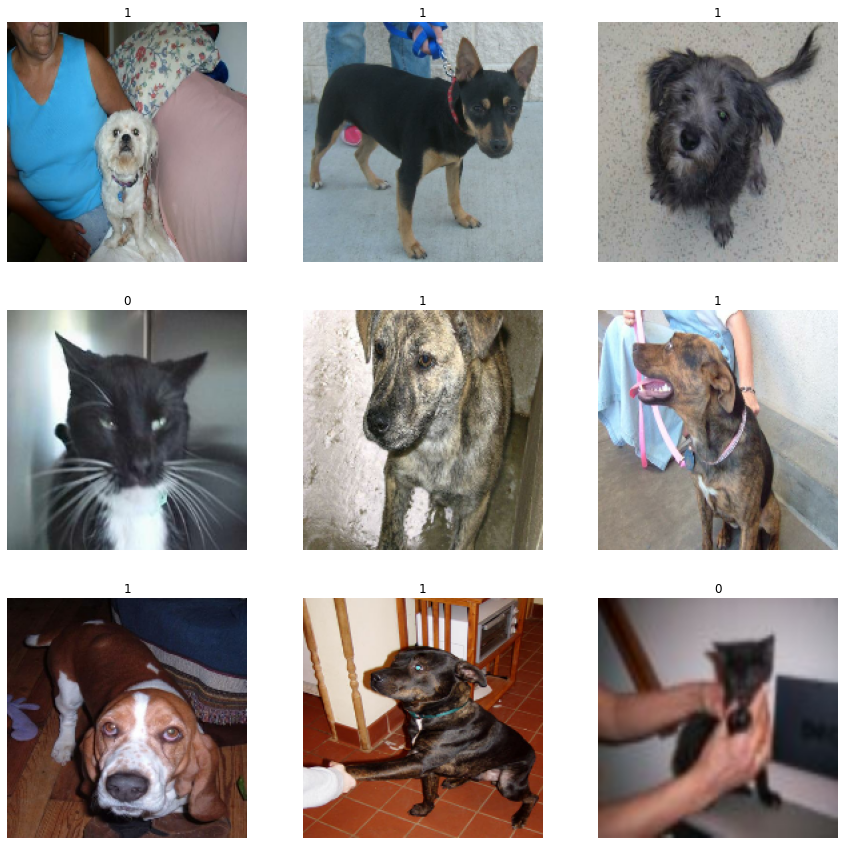

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 15))
for images, labels in train_ds.take(10):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

DATA AUGMENTATION

+ Data Augmentation is a Method to Generate more training data.
+ From the Existing data by doing transformations in the Images.
+ By doing the RandomFlip and RandomRotation.
+ This will reduce the Overfitting.
+ And will generate more Training Data.

In [12]:
data_augmentation = keras.Sequential([layers.RandomFlip("horizontal"),layers.RandomRotation(0.1)])
augmented_images = data_augmentation(images)

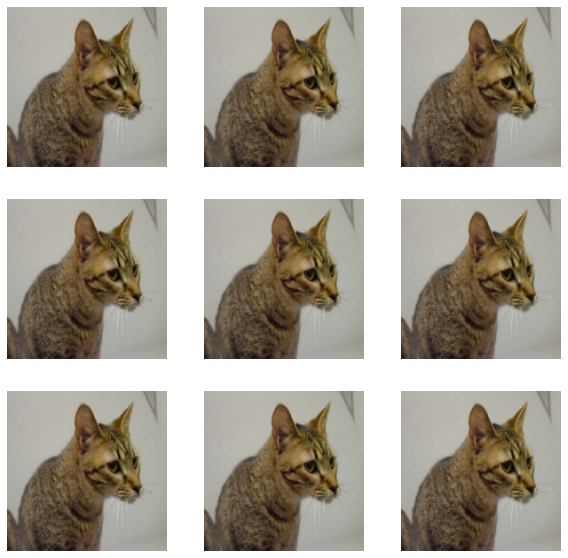

In [18]:
## visualize the augmented images
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        # augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[100].numpy().astype("uint8"))
        plt.axis("off")

STANDARDIZE THE DATA

+ The Image is already in Standard Size (180x180)
+ their RGB channel values are ranges from `[0-255]`
+ For the neural network, we have to standardize the values to `[0-1]`.

TWO OPTION TO PREPROCESS THE DATA.

1. Make it Part of the Model

    + with this the data augmentation will not happen on device.
    + it will benefit from GPU acceleration.
    + the data augmentation is inactive at the test time.
    + So the input samples only be augmented by `fit()`, but not on `evaluate()`, and `predict()`.

      ```
      inputs = keras.Input(shape=input_shape)
      x = data_augmentation(inputs)
      x = layers.Rescaling(1./255)(x)
      ...  # Rest of the model
      ```

2. Apply it to the Dataset.

    + to obtain the dataset that yields batches of augmented images.
    + with this option, data augmentation will happen on CPU.

      ```
      augmented_train_ds = train_ds.map(
      lambda x, y: (data_augmentation(x, training=True), y))
      ```







CONFIGURE THE DATASET FOR PERFOMANCE

In [21]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

BUILD THE MODEL

+ We are building the Small Version of Xception Network

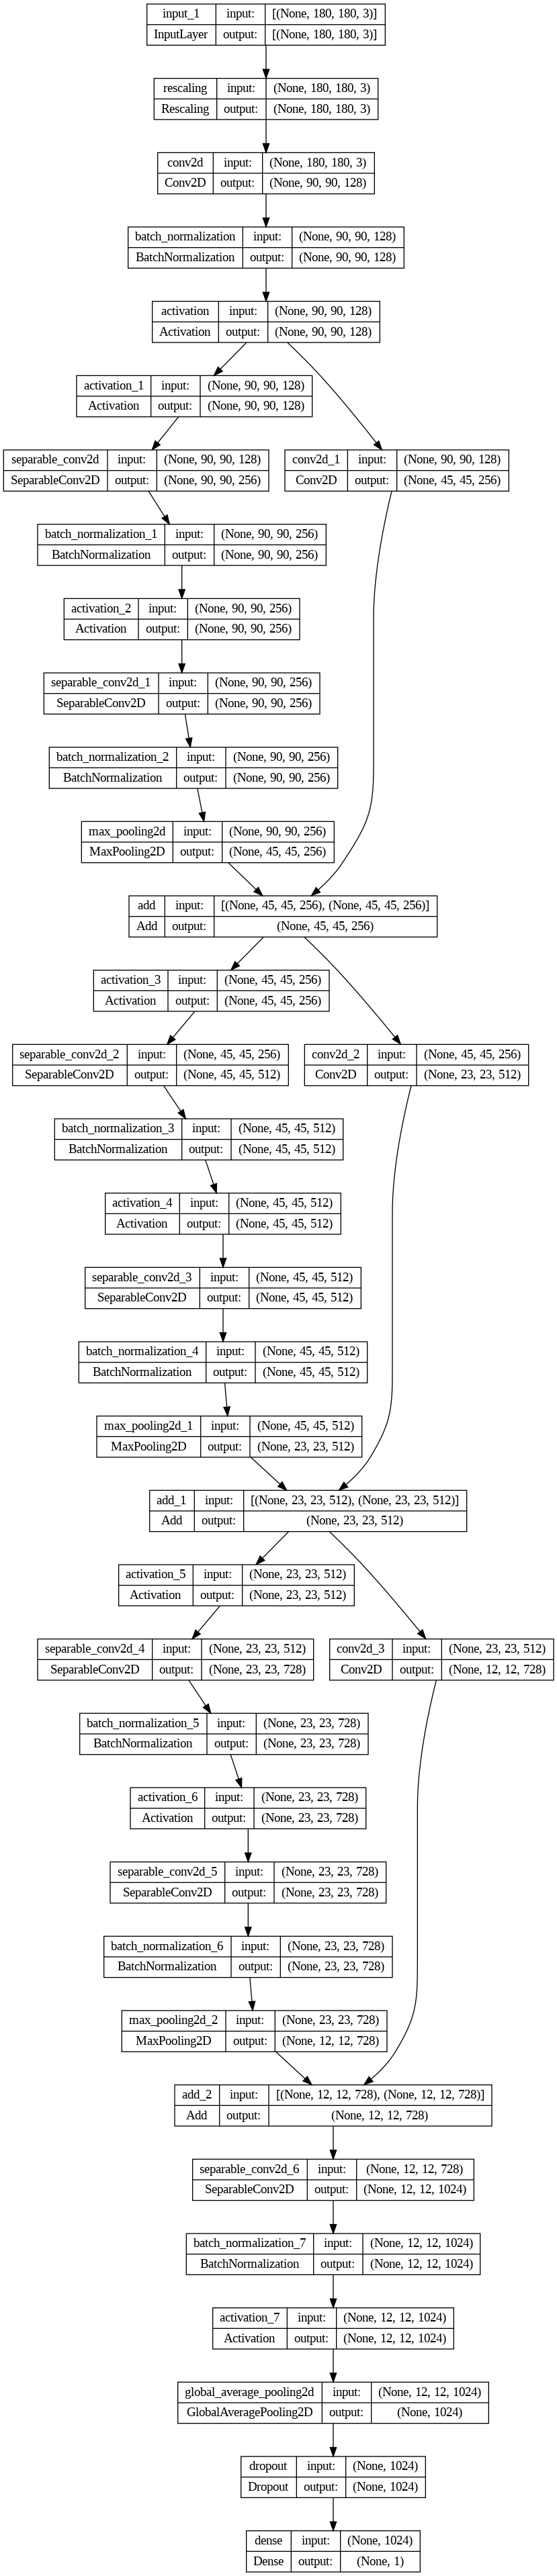

In [22]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

In [23]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 180, 180, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 90, 90, 128)  3584        ['rescaling[0][0]']              
                                                                                                  
 batch_normalization (BatchNorm  (None, 90, 90, 128)  512        ['conv2d[0][0]']             

COMPILE AND TRAIN THE MODEL

In [24]:
epochs = 10

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/10
147/147 [==============================] - 376s 2s/step - loss: 0.6484 - accuracy: 0.6466 - val_loss: 0.7780 - val_accuracy: 0.4957
Epoch 2/10
147/147 [==============================] - 351s 2s/step - loss: 0.5084 - accuracy: 0.7541 - val_loss: 1.0195 - val_accuracy: 0.4957
Epoch 3/10
147/147 [==============================] - 354s 2s/step - loss: 0.4192 - accuracy: 0.8136 - val_loss: 1.4883 - val_accuracy: 0.4957
Epoch 4/10
147/147 [==============================] - 360s 2s/step - loss: 0.3544 - accuracy: 0.8454 - val_loss: 0.6560 - val_accuracy: 0.6613
Epoch 5/10
147/147 [==============================] - 357s 2s/step - loss: 0.3069 - accuracy: 0.8684 - val_loss: 0.4068 - val_accuracy: 0.8249
Epoch 6/10
147/147 [==============================] - 365s 2s/step - loss: 0.2720 - accuracy: 0.8857 - val_loss: 0.2935 - val_accuracy: 0.8684
Epoch 7/10
147/147 [==============================] - 358s 2s/step - loss: 0.2462 - accuracy: 0.8954 - val_loss: 0.6348 - val_accuracy: 0.7935

We get to >90% validation accuracy after training for 10 epochs on the full dataset .

TEST THE MODEL

In [25]:
img = keras.preprocessing.image.load_img(
    "PetImages/Cat/6779.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = float(predictions[0])
print(f"This image is {100 * (1 - score):.2f}% cat and {100 * score:.2f}% dog.")

1/1 [==============================] - 2s 2s/step
This image is 39.13% cat and 60.87% dog.


***